# Gradient Descent

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

By Mike Gelbart (converted to Julia by Jason Chau)

In [2]:
using Distributions
using MultivariateStats
using Plots
using Plots.PlotMeasures
using Printf
using LinearAlgebra
#= run once
    using Pkg
    Pkg.add("Optim")
=#
using Optim

Learning goals:

- Why do we need gradient descent? Can't we use th normal equations for everything?
- What is the step size/learning rate?
- How do I implement gradient descent?
- What's the difference between the data space and the parameter space?

## Amin

- Assignment 3 released
- Midterm: October 18th at 6:30pm in BUCH A102 and A104
    - Duration: 80min

## Motivation 1: large-scale least squares

- Normal equations costs $O(nd^2+d^3)$
- Can we do better for large $d$?

## Motivation 2: least squares with outliers

In [8]:
# ENV["GRDIR"]=""
# Pkg.build("GR")
# using Pkg
# Pkg.add("LaTeXStrings")
# pyplot()

Plots.PyPlotBackend()

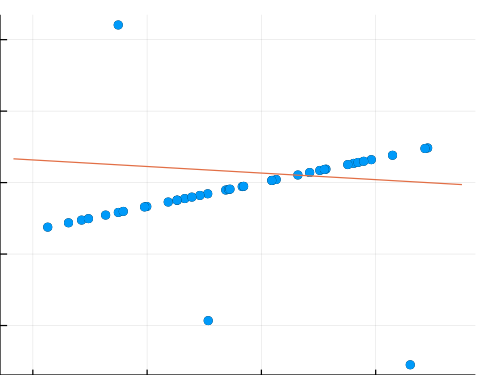

In [3]:
function gen_outlier_data(;n=40,Noutliers=3)
    # generate random data
    x = rand(Normal(),n)
    y = 10*x
    # add random outliers
    y[1:Noutliers] = -100*(x[1:Noutliers]+rand(Normal(),Noutliers))

    X = reshape(x,(n,1)) # reshape for linear regression
    
    return (X,y)
end

# fit a linear regression model
(X,y) = gen_outlier_data()
lr = llsq(X,y)
function predict(x)
    return lr[1] + lr[2]*x
end

grid = range(minimum(X)-0.3,stop=maximum(X)+.3,length=1000)

plot(X,y,
    seriestype=:scatter,
    markersize=20,
    legend=false,
    size=(2000,1500),
    thickness_scaling=5,
    left_margin=-80px,
    bottom_margin=-45px
)
plot!(grid,broadcast(predict,grid))

Can we do better?

## Gradient descent

#### use of the gradient: optimization

The gradient gives us the direction of fastest increase of a function with respect to its parameters.

The (negative) gradient gives us a direction of travel (fastest decrease), if we want to minimize a function!

If we are trying to minimize $f(w)$, then gradient descent works by starting with some initial guess $w^0$ and then updating with

$$w^{t+1} = w^t - \alpha^t\, \nabla f(w^t)$$

- $w^t$ refers to the value of $w$ (the weights/parameters) at iteration $t$ of gradient descent.
- $\alpha^t$ is the "learning rate" or "step size" at iteration $t$.
- Gradient descent is an algorithm for minimization. The corresponding method for maximization is called gradient ascent.
- The step size should be small to guarantee that the loss goes down. If it's too big the loss could go up.
- Converges to a global optimium if $f$ is convex. 

- We can use this to minimize losses like the squared error (above) and robust losses (coming soon):


$$ f(w) = \sum_{i=1}^n\left(w^T x_i-y_i\right)^2 $$



#### magnitude vs. direction

In the above we are making use of the magnitude of the gradient, not just its direction. This actually makes sense. When the magnitude is small, we are in a flatter area and want to take smaller steps. 

However, some methods exist that just use the direction. For example given a direction you can do a [line search](https://en.wikipedia.org/wiki/Line_search).

#### picking the learning rate

In general picking $\alpha$ is a pain, especially when we get to stochastic gradient descent (later in the course). There is theory on this regarding convergence guarantees and convergence rates. The learning rate is sometimes decreased over time. Fancier methods pick the learning rate adaptively (see a3 code).

#### termination conditions

We can stop when $||\nabla f||$ is sufficiently small (because this indicates we're at a local minimum), or when a specified maximum number of iterations are reached (because we want to limit the computational expense).

## Least squares via normal equations vs. gradient descent:

- Normal equations cost $O(nd^2 + d^3)$.
  - forming $X^TX$ costs $O(nd^2)$ and solving a $d\times d$ linear system costs $O(d^3)$
- Gradient descent costs $O(ndt)$ to run for $t$ iterations.
  - computing $\nabla f(w)=X^TXw-X^Ty$ only costs $O(nd)$ 
- Gradient descent can be faster when $d$ is very large
  - well, this is just big-O, we don't know the coeffcients
  - matrix operations are fast; iteration is slow, especially in Python
  - assuming $t$ doesn't depend on $d$ (see CPSC 540)
  - one advantage is that we can control the accuracy by controlling the number of iterations

## Experiments: does it work?

In [19]:
# generate data
d = 10
n = 1000

X = rand(Normal(),n,d)
y = rand(Normal(),n)

1000-element Array{Float64,1}:
  2.054647150943276  
  1.207473180866666  
 -0.47792947643876954
 -1.460928409364932  
 -0.3006121417811932 
 -1.9968464747372672 
 -0.1285219090667731 
  0.4450246690343144 
  0.5888910589145907 
 -0.2069410464854636 
 -1.2310111080923543 
  0.05874169316501323
 -0.36360540520446294
  ⋮                  
 -0.14727865634373283
 -0.8398518013878338 
  0.2496131164060855 
  0.3560637238343483 
 -0.14963192658269955
  0.20339407998985495
 -0.9359934881981689 
  0.9320768190558173 
  0.8238273126778948 
 -0.6201891387440464 
 -0.3585623272458735 
 -0.6884156417898623 

#### Approach 1: sklearn's `LinearRegression` in Python

In [27]:
# least squares

lr = llsq(X,y)
Printf.@printf("Intercept: %f\n",lr[end])
Printf.@printf("Weights: %s",lr[1:end-1])

Intercept: 0.053389
Weights: [0.0525225, -0.00708656, 0.00274481, 0.00555818, -0.013154, -0.0100317, -0.0103753, 0.0159919, -0.0180807, -0.00160599]

#### Approach 3: gradient descent

In [28]:
alpha = 1e-5

grad_f(w) = X'*(X*w) - X'*y

grad_f (generic function with 1 method)

In [32]:
w = zeros(size(X)[2]) # initial guess

g = grad_f(w)
while LinearAlgebra.norm(g) > 0.001
    g = grad_f(w)
    
    w = w - alpha*g
end
    
Printf.@printf("Intercept: %f\n", w[end])
Printf.@printf("Weights: %s", w[1:end-1])

Intercept: 0.053305
Weights: [0.0525097, -0.00706368, 0.00274044, 0.00561045, -0.0130505, -0.0100767, -0.010404, 0.0159321, -0.0180885]

From the above, you can see that all three methods generate roughly the same weights. This is comforting.

## Robust regression with gradient descent

Is this only useful when $d$ is large?

Answer: no! Another use: changing the loss function (so we can't use the normal equations).

For example let's consider the absolute value objective:

$$ f(w) = \sum_{i=1}^n\left|w^T x_i-y_i\right| $$

This is the sum of absolute values instead of the sum of squares. This will hopefully give us robust regression because big distances aren't amplified in the objective (let's dwell on this reasoning for a bit).

**Note on smoothness:** Non-smooth functions are harder to minimize than smooth functions. Unlike smooth functions, the gradient may not get smaller near a minimizer. 

Experiments below: this time we add outliers to mess up least squares, and then try switching to the absolute value objective. 

w = [-0.250539]
b = -7.304202

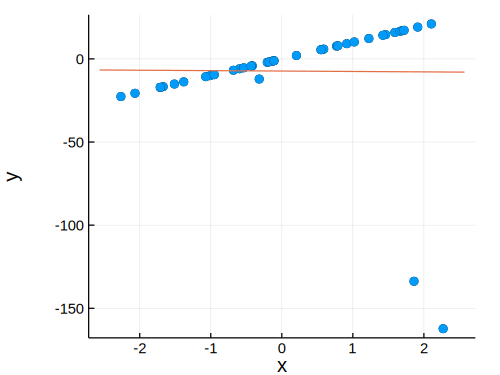

In [22]:
(X,y) = gen_outlier_data()
x = X[:]

# fit a linear regression model
lr = llsq(X,y)
predict(x) = lr[end].+x*lr[1:end-1]'

Printf.@printf("w = %s\n", lr[1:end-1])
Printf.@printf("b = %f", lr[2])

plot(X,y,
    seriestype=:scatter,
    markersize=20,
    size=(2000,1500),
    xlabel="x",
    ylabel="y",
    legend=false,
    thickness_scaling=5,
    left_margin=-100px,
    bottom_margin=-45px
)
grid = range(minimum(X)-0.3,stop=maximum(X)+0.3,length=1000)
plot!(grid, predict(grid))

(BONUS "SLIDE")

For linear regression in one dimension our L1 objective becomes

$$f(w,\beta)=\displaystyle \sum_{i=1}^n\left|w x_i + \beta - y_i\right| $$

The gradient (where defined) is

$$\frac{\partial f}{\partial w} = \sum_{i=1}^n  x_i \textrm{sign}\left(w x_i + \beta - y_i\right)$$ 

$$\frac{\partial f}{\partial \beta} = \sum_{i=1}^n  \textrm{sign}\left(w x_i + \beta - y_i\right)$$ 



w = 9.994218
β = -0.014016

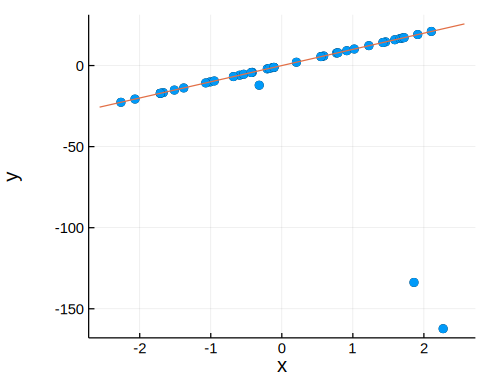

In [24]:
w = 0
β = 0
α = 1

Nsteps = 1000

for t in 1:Nsteps-1
    dLdw = sum(x.*broadcast(sign,(w .* x).+(β.-y)))
    dLdβ = sum(broadcast(sign,(w .* x).+(β.-y)))
    w -= (α/t)*dLdw # we are decreasing the step size over time to deal with the non-smoothness
    β -= (α/t)*dLdβ # the details are beyond the scope of the course, see CPSC 540
end
    
Printf.@printf("w = %f\n",w)
Printf.@printf("β = %f",β)

plot(x,y,
    seriestype=:scatter,
    xlabel="x",
    ylabel="y",
    markersize=20,
    size=(2000,1500),
    thickness_scaling=5,
    left_margin=-100px,
    bottom_margin=-45px,
    legend=false
)
grid = range(minimum(x)-0.3,stop=maximum(x)+0.3,length=1000)
predict(x) = x*w'.+β
plot!(grid,predict(grid))

## Gradient descent is not just for robust regression!

We can use it for a large class of models. With some caveats, **you are now empowered to minimize things!** 

## Why gradient descent?

A common misconception from previous terms of CPSC 340:

> We use gradient descent because of the non-smooth loss.

Not true!! We use it for large $d$. We also use it because the normal equations only apply to linear least squares. We can use gradient descent in all sorts of cases. The non-smoothness just complicates things a bit.

## (bonus "slide") Gradient descent is not the only game in town 

There are many optimization algorithms out there. Gradient descent is not applicable in all contexts and it is certainly not the best method in all contexts! We focus on it because:

- it is relatively simple to understand and implement.
- the time complexity is linear in $d$ per iteration.
- we can generalize it to _stochastic gradient descent_, which is coming later in the course.

See CPSC 406 for much more. (Through Python's scientific libraries like [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) you can access a variety of methods as black-box optimizers. For example see scipy's [implementation of the popular L-BFGS method](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_l_bfgs_b.html), which is more sophisticated but still linear in $d$ per iteration.)

## The different decisions we make

We should try to keep separate (in our minds) the following choices:

- the model (e.g. linear)
- the loss (e.g. squared error)
- the optimization method (e.g. gradient descent)

We can (roughly) pick these independently of each other. Not quite because the choice of optimization method may depend on the choice of model/loss: e.g. we can use the normal equations as our optimization method if we're doing least squares.

## What space am I in?

A key skill is being able to move around (conceptually) between $x$ (data) space and $w$ (parameter) space. The above plots are in $y$ vs. $x$ space. Here's what the loss looks like in parameter space:

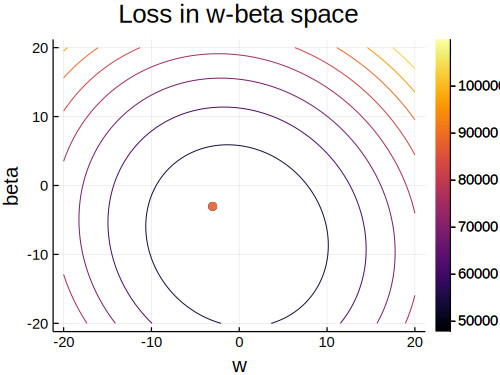

In [25]:
function plot_loss(loss_fun, X, y) # reading/understanding this plotting code is optional
    m = 100
    w_lin = range(-20.0, stop=20.0, length=m)
    b_lin = range(-20.0, stop=20.0, length=m)
    
    pred = w_lin*X' .+ b_lin
    
    contour(w_lin, b_lin, (w,b) -> sum((w.*X.+b-y).^2),
        nlevels=10,
        w=4,
        xlabel="w",
        ylabel="beta",
        title="Loss in w-beta space",
        size=(2000,1500),
        thickness_scaling=5,
        left_margin=-95px,
        bottom_margin=-40px
    )
    
    loss = loss_fun(pred, y)
    imin = argmin(loss)
    plot!([w_lin[imin]], [b_lin[imin]], markersize=20, seriestype=:scatter, legend=false)
end
squared_loss_fun(pred,y) = [sum((pred[i,:]-y).^2) for i in 1:size(pred)[1]]
plot_loss(squared_loss_fun, X, y)

Key intuition: every point in weight space corressponds to a _model_ (in this case a line) in input-output space.

- In general, doing supervised learning in $d$ dimensions, the data space will be mapping from $d$ dimensions to $1$ dimensional. 
- For linear models, the number of parameters is $d+1$ ($d$ weights plus an intercept), but this isn't necessarily the case for other models.

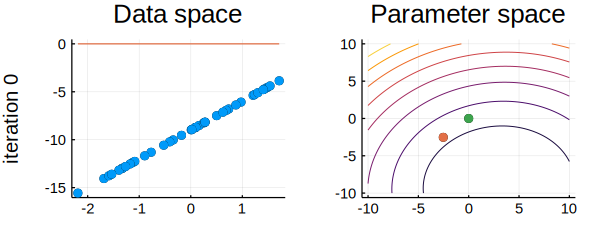

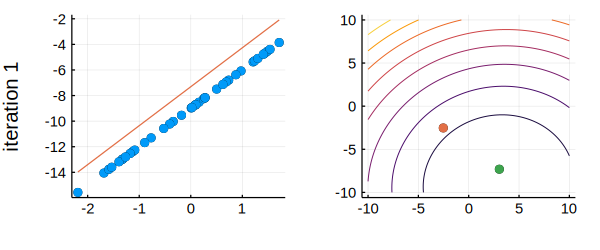

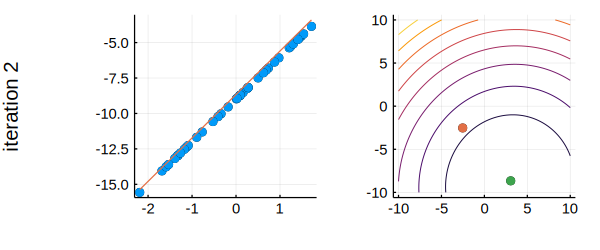

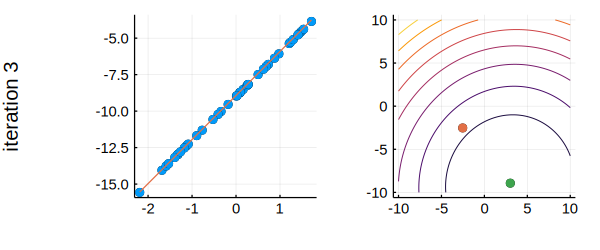

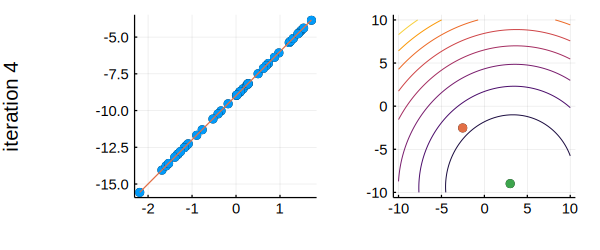

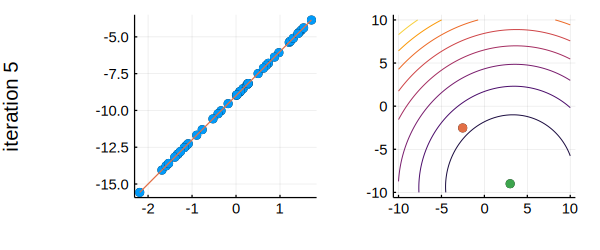

w = 3.000952
β = -8.996891

In [157]:
# a few iterations of GD showing the loss space and line space
# you don't need to read/understand this code (it's optional)

x = rand(Normal(),40)
y = 3 .* x .- 9
X = reshape(x,(40,1))

w = 0
β = 0
α = 0.02

Nsteps = 5

function make_plot_pairs(w,β,t;titles=false)
    scatter = plot(x,y,markersize=20,
        seriestype=:scatter,
        size=(1000,750),
        ylabel="iteration $t",
        title = titles ? "Data space" : "",
        thickness_scaling = 5,
        left_margin = -80px,
        legend=false
    )
    model = plot!(x,w .* x .+ β)
    
    m = 100
    w_lin = range(-10.0, stop=10.0, length=m)
    β_lin = range(-10.0, stop=10.0, length=m)
    pred = w_lin*X'.+β_lin
    loss = squared_loss_fun(pred, y) 
    imin = argmin(loss)
    CS = contour(w_lin, β_lin, (w,b)->sum((w.*X.+b - y).^2),
        nlevels=10,
        w=4,
        title=titles ? "Parameter space" : "",
        size=(1000,750),
        thickness_scaling=5,
        left_margin=-80px,
        legend=false
    )
    plot!([w_lin[imin]], [β_lin[imin]], seriestype=:scatter, markersize=20)
    plot!([w], [β], seriestype=:scatter, markersize=20)
    display(plot(scatter,CS,
        size=(2400,1000)
    ))
end

# plt.figure(figsize=(8, 20))
make_plot_pairs(w,β,0,titles=true)    
for t in 0:Nsteps-1
    dLdw = sum(x .* (w .* x .+ β-y))
    dLdβ = sum(w .* x .+ β-y)
    w -= α*dLdw
    β -= α*dLdβ
    
    make_plot_pairs(w,β,t)
end
Printf.@printf("w = %f\n",w)
Printf.@printf("β = %f",β)

### Robust regression intuition (in one dimension)

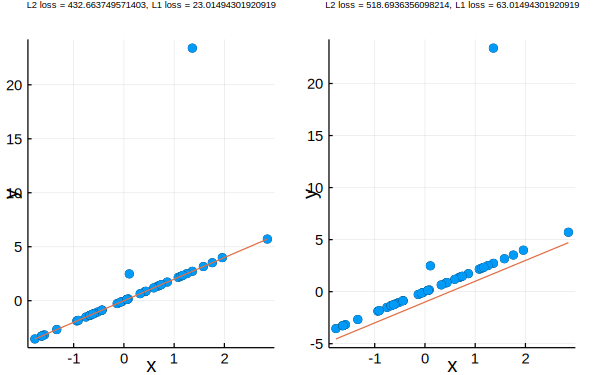

In [199]:
n = 40
Noutliers = 3
x = rand(Normal(),n)
y = 2 .* x
y[1:Noutliers] = y[1:Noutliers] -20*rand(Normal(),Noutliers) # outliers are all negative

# plt.figure(figsize=(10,3))
# plt.subplot(1,2,1)
plot1 = plot(x,y,
    seriestype=:scatter,
    markersize=20,
    xlabel="x",
    ylabel="y",
    thickness_scaling=5,
    size=(1000,750),
    left_margin=-80px,
    bottom_margin=-45px,
    titlefontsize=5,
    legend=false
)
pred1 = 2 .* x
L2_loss = sum((pred1-y).^2)
L1_loss = sum(broadcast(abs,pred1-y))
plot!(x, pred1,
    title="L2 loss = $L2_loss, L1 loss = $L1_loss"
)
# plt.subplot(1,2,2)
plot2 = plot(x,y,markersize=20,
    seriestype=:scatter,
    xlabel="x",
    ylabel="y",
    thickness_scaling=5,
    size=(1000,750),
    left_margin=-80px,
    bottom_margin=-45px,
    legend=false,
    titlefontsize=5
)
pred2 = 2 .* x .- 1
L2_loss = sum((pred2-y).^2)
L1_loss = sum(broadcast(abs,pred2-y))
plot!(x, pred2,
    title="L2 loss = $L2_loss, L1 loss = $L1_loss"
)
display(plot(plot1,plot2,size=(2400,1500)))

Consider what happens to the **L1** loss if we move the line down by 1 unit towards the outliers:

- The loss goes down by 1 for 3 points, and up by 1 for 37 points, so overall it goes up by 34 (see above).
- So, even the slightest perturbation towards the outliers is unfavorable: it really is robust!
- Every point gets an equal vote.

Consider what happens to the **L2** loss if we move the line down by 1 unit towards the outliers:

- The loss goes up very slightly for the 37 points, but goes down massively for 3 points, so overall it goes down (see above).
- Thus, moving the line is favorable. 
- 3 points have overruled 37 points.

In fact, this is an extension of the idea that the median of a bunch of numbers minimizes the L1 error and the mean minimizes the L2 error. The robustness of the median that we discussed early on in the course is this same effect. This is also related to $k$-means taking the mean and thus minimizing L2.

### Digression: mean and median

- The **mean** is the value that minimizes the **L2** error between itself and a set of numbers.
- The **median** is the value that minimizes the **L1** error between itself and a set of numbers.

In [184]:
nums = [1,7,4,-3,3.4,1000,50]

Printf.@printf("Mean of the numbers: %f\n", mean(nums))
Printf.@printf("Median of the numbers: %f\n", median(nums))

Mean of the numbers: 151.771429
Median of the numbers: 4.000000


In [217]:
l2_loss(x) = sum((x-nums).^2)
l1_loss(x) = sum(broadcast(abs,x-nums))

x0 = zeros(7)

Printf.@printf("Minimizer of L2: %s\n", Optim.minimum(optimize(l2_loss, x0)))
Printf.@printf("Minimizer of L1: %s", Optim.minimum(optimize(l1_loss, x0)))

Minimizer of L2: 10065.197737618111
Minimizer of L1: 758.9674393903247